In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax" # or "tensorflow", "torch"

import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plot
sns.set(style="whitegrid")

import tensorflow as tf
import keras_cv
import keras_core as keras
from keras_core import ops

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using JAX backend.


## Configuration

Please feel free to change the configuration and run experiments.

In [2]:
class Config:
    is_submission = False
    
    # Reproducibility
    SEED = 42
    
    # Training
    train_csv_path = "/kaggle/input/UBC-OCEAN/train.csv"
    train_thumbnail_paths = "/kaggle/input/UBC-OCEAN/train_thumbnails"
    img_size = 256
    batch_size = 8
    learning_rate = 5e-4
    epochs = 16
    
    # Inference
    test_csv_path = "/kaggle/input/UBC-OCEAN/test.csv"
    test_thumbnail_paths = "/kaggle/input/UBC-OCEAN/test_thumbnails"

config = Config()

To help with reproducibility we set the seed of the Pseudo Random Number Generator.

In [3]:
keras.utils.set_random_seed(seed=config.SEED)

# Training

## Dataset

In this notebook we train on the thumbnails for quick iteration. Also note that we are NOT going to work on the anomaly detection part of the competition here. We will train a simple image classification model that will classify the scans of biopsy samples to their respective subtypes.

num_rows=513
num_unique_images=513
num_unique_labels=5
unique_labels=array(['HGSC', 'LGSC', 'EC', 'CC', 'MC'], dtype=object)


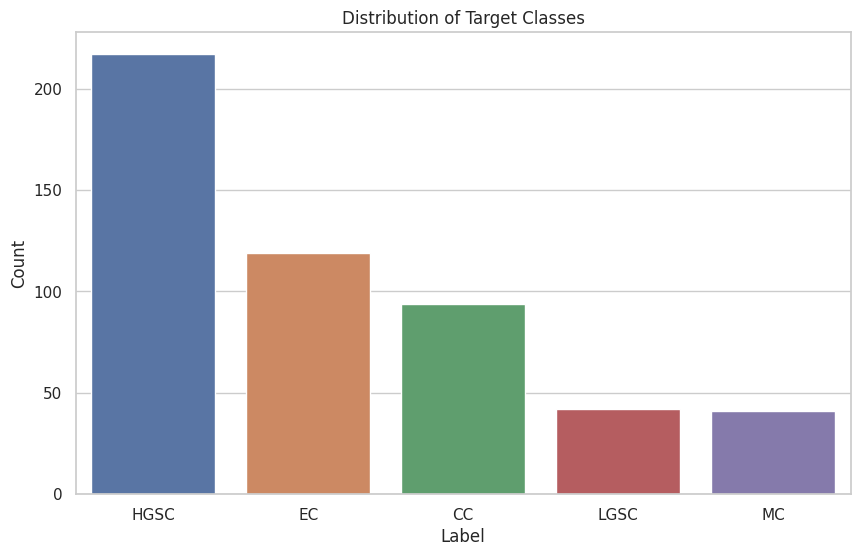

In [4]:
if not config.is_submission:
    df = pd.read_csv(config.train_csv_path)

    # Create the thumbnail df where is_tma == False
    df = df[df["is_tma"] == False]
    
    # Get basic statistics about the dataset
    num_rows = df.shape[0]
    num_unique_images = df['image_id'].nunique()
    num_unique_labels = df['label'].nunique()
    unique_labels = df['label'].unique()

    print(f"{num_rows=}")
    print(f"{num_unique_images=}")
    print(f"{num_unique_labels=}")
    print(f"{unique_labels=}")
    
    # Plot the distribution of the target classes
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
    plt.title('Distribution of Target Classes')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

Note the imbalance in the distribution of target classes.

## Perform one-hot encoding

In [5]:
if not config.is_submission:
    # Perform one-hot encoding of the 'label' column and explicitly convert to integer type
    df_one_hot = pd.get_dummies(df["label"], prefix="label").astype(int)

    # Concatenate the original DataFrame with the one-hot encoded labels
    train_df = pd.concat([df["image_id"], df_one_hot], axis=1)

    # Get the thumbnail image paths
    train_df["image_thumbnail_path"] = train_df["image_id"].apply(lambda x: f"{config.train_thumbnail_paths}/{x}_thumbnail.png")
    
    image_thumbnail_paths = train_df["image_thumbnail_path"].values
    labels = train_df[[col for col in train_df.columns if col.startswith("label_")]].values

    label_names = [col for col in train_df.columns if col.startswith("label_")]
    name_to_id = {key.replace("label_", ""):value for value,key in enumerate(label_names)}
    id_to_name = {key:value for value, key in name_to_id.items()}
    
    # Save to dictionary to disk
    with open("id_to_name.pkl", "wb") as f:
        pickle.dump(id_to_name, f)

In [6]:
train_df

,image_id,label_CC,label_EC,label_HGSC,label_LGSC,label_MC,image_thumbnail_path
0,4,0,0,1,0,0,/kaggle/input/UBC-OCEAN/train_thumbnails/4_thu...
1,66,0,0,0,1,0,/kaggle/input/UBC-OCEAN/train_thumbnails/66_th...
3,281,0,0,0,1,0,/kaggle/input/UBC-OCEAN/train_thumbnails/281_t...
4,286,0,1,0,0,0,/kaggle/input/UBC-OCEAN/train_thumbnails/286_t...
5,431,0,0,1,0,0,/kaggle/input/UBC-OCEAN/train_thumbnails/431_t...
...,...,...,...,...,...,...,...
533,65022,0,0,0,1,0,/kaggle/input/UBC-OCEAN/train_thumbnails/65022...
534,65094,0,0,0,0,1,/kaggle/input/UBC-OCEAN/train_thumbnails/65094...
535,65300,0,0,1,0,0,/kaggle/input/UBC-OCEAN/train_thumbnails/65300...
536,65371,0,0,1,0,0,/kaggle/input/UBC-OCEAN/train_thumbnails/65371...


Taking pointers from the [image classification on imbalanced dataset guide](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data), we create the class weights which will be used to train the model.

In [7]:
if not config.is_submission:
    class_weights = np.sum(labels) - np.sum(labels, axis=0)
    class_weights = class_weights / np.sum(class_weights) # Normalize the weights

    class_weights = {idx:weight for idx, weight in enumerate(class_weights)}

    for idx, weight in class_weights.items():
        print(f"{id_to_name[idx]}: {weight:0.2f}")

CC: 0.20
EC: 0.19
HGSC: 0.14
LGSC: 0.23
MC: 0.23


## Creating the `tf.data.Dataset` pipeline

In [8]:
def read_image(path):
    file = tf.io.read_file(path)
    image = tf.io.decode_png(file, 3)
    image = tf.image.resize(image, (config.img_size, config.img_size))
    image = tf.image.per_image_standardization(image)
    return image

In [9]:
if not config.is_submission:
    x = (
        tf.data.Dataset.from_tensor_slices(image_thumbnail_paths)
        .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    )
    y = tf.data.Dataset.from_tensor_slices(labels)

    # Zip the x and y together
    ds = tf.data.Dataset.zip((x, y))
    
    # Create the training and validation splits
    val_ds = (
        ds
        .take(50)
        .batch(config.batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    train_ds = (
        ds
        .skip(50)
        .shuffle(config.batch_size * 10)
        .batch(config.batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

Visualizing the dataset is always fruitful. Below we will sample from the dataset and visualize some images.

In [10]:
# if not config.is_submission:
#     images, labels = train_ds.take(1).get_single_element()

#     keras_cv.visualization.plot_image_gallery(
#         images,
#         value_range=(0, 1),
#         rows=2,
#         cols=2,
#     )

## Build the Model

[List of Keras CV models](https://keras.io/api/keras_cv/models/)

In [11]:
# Load the image and text backbones with presets
resnet_backbone = keras_cv.models.ResNetV2Backbone.from_preset(
    "resnet152_v2",
)
resnet_backbone.trainable = False

image_inputs = resnet_backbone.input
image_embeddings = resnet_backbone(image_inputs)
image_embeddings = keras.layers.GlobalAveragePooling2D()(image_embeddings)

x = keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(image_embeddings)
x = keras.layers.Dense(units=1024, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(units=512, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(units=256, activation="relu")(x)
outputs = keras.layers.Dense(units=5, activation="softmax")(x)

# Build the model with the Functional API
model = keras.Model(
    inputs=image_inputs,
    outputs=outputs,
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)     │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ res_net_v2_backbone             │ (None, None, None, 2048)  │ 58,331,648 │
│ (ResNetV2Backbone)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (None, 2048)              │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, 2048)              │      8,192 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 1024)              │  2,098,176 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 1024)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 5)                 │      1,285 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 61,095,429 (233.06 MB)

 Trainable params: 2,759,685 (10.53 MB)

 Non-trainable params: 58,335,744 (222.53 MB)

In [ ]:
if not config.is_submission:
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config.learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    history = model.fit(
        train_ds,
        epochs=config.epochs,
        validation_data=val_ds,
        class_weight=class_weights,
    )
    
    model.save_weights("ucb_ocean_checkpoint.weights.h5")

Epoch 1/16
58/58 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.3764 - loss: 0.2816 - val_accuracy: 0.5200 - val_loss: 1.4735
Epoch 2/16


## Inference

In [ ]:
if config.is_submission:
    df = pd.read_csv(config.test_csv_path)
    df["image_path"] = df["image_id"].apply(lambda x: f"{config.test_thumbnail_paths}/{x}_thumbnail.png")
    
    # Load the model weights
    model.load_weights("/kaggle/input/kerascv-train-and-infer-on-thumbnails/ucb_ocean_checkpoint.weights.h5")
    
    # Load the id to name dictionary
    with open("/kaggle/input/kerascv-train-and-infer-on-thumbnails/id_to_name.pkl", "rb") as f:
        id_to_name = pickle.load(f)

In [ ]:
if config.is_submission:
    predicted_labels = []

    for index, row in df.iterrows():
        # Get the image path
        image_path = row["image_path"]

        # Get the image
        image = read_image(image_path)[None, ...]

        # Predict the label
        logits = model.predict(image)
        pred = ops.argmax(logits, axis=-1).tolist()[0]

        # Map the pred to the name
        label = id_to_name[pred]

        predicted_labels.append(label)

    # Add the predicted labels to the csv
    df["label"] = predicted_labels

In [ ]:
if config.is_submission:
    # Create the submission
    submission_df = df[["image_id", "label"]]
    submission_df.to_csv("submission.csv", index=False)

# Directions Ahead

There are a lot of directions one can take to iterate on top of this starter notebook. Some of them are:

- Play with the various hyperparameters (in the configuration) to get better results
- Come up with a strategy for anomaly detection
- Use different models from the Keras CV presets